In [1]:
import os
import pandas as pd
import pandas_profiling as pf
from datetime import datetime as dt
import calendar
import pickle

In [2]:
#Initializing file paths
raw_dir = os.path.join(os.pardir,os.pardir,'data','raw')
processed_dir = os.path.join(os.pardir,os.pardir,'data','processed')

In [3]:
data_path = os.path.join(raw_dir,'dev.csv')

In [4]:
data_df = pd.read_csv(data_path)

In [5]:
data_df.head()

,ex_id,user_id,prod_id,rating,label,date,review
0,11,934,0,5.0,1,2014-01-20,"all around good place, cozy, I came in and did..."
1,17,940,0,4.0,0,2014-09-16,"For lunch, my friend and I had: -Lamb sandwich..."
2,20,943,0,5.0,0,2014-05-24,Some good Big Greek cooking!! Came to City on ...
3,30,953,0,4.0,0,2013-10-17,So... as you may notice from some of my other ...
4,43,966,0,3.0,0,2012-12-19,"I don't understand the whole ""You can't order ..."


#### Summary Statistics

In [6]:
# A quick summary statistics on all data.
data_df.describe()

,ex_id,user_id,prod_id,rating,label
count,35918.000000,35918.000000,35918.000000,35918.000000,35918.000000
mean,179060.247035,53625.825853,457.526811,4.023275,0.101565
std,103651.452541,45583.076589,260.532673,1.055449,0.302079
min,11.000000,923.000000,0.000000,1.000000,0.000000
25%,89904.000000,13781.500000,247.000000,4.000000,0.000000
50%,178631.500000,40110.000000,465.000000,4.000000,0.000000
75%,268548.750000,86310.000000,668.000000,5.000000,0.000000
max,358935.000000,161140.000000,922.000000,5.000000,1.000000


In [7]:
# Checking the number users in the data
data_df.user_id.count()

35918

In [8]:
# Checking the number of unique users in the data
len(data_df.user_id.unique())

28040

*_Assumption 1: Since unique user count is less than user count we can assume that some users wrote multiple reviews or thesame review by thesame user was added multiple times. (We'll confirm which one later)_*

In [9]:
# Checking the number ex_id in the data
data_df.ex_id.count()

35918

In [10]:
len(data_df.ex_id.unique())

35918

*_Question 1: What's `ex_id`, hmmm? (Could it be a unique id for each review since it's value is unique for each review)_*

Since the df.describe() is best suited for numeric features its best to call it after transforming the review words into to a bag of words representation.

In [11]:
# Seperating the actual reviews and labels in a separate dataframe

review_df = data_df[['review','label']].copy()
review_df.head()

,review,label
0,"all around good place, cozy, I came in and did...",1
1,"For lunch, my friend and I had: -Lamb sandwich...",0
2,Some good Big Greek cooking!! Came to City on ...,0
3,So... as you may notice from some of my other ...,0
4,"I don't understand the whole ""You can't order ...",0


In [12]:
import nltk

In [13]:
# nltk.download('stopwords')
# nltk.download('punkt')

In [14]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.util import bigrams
import string
import re

In [15]:
stop_words = set(stopwords.words('english')) 

In [16]:
data_df['tokens'] = data_df['review'].apply(lambda x: word_tokenize(x) )

In [17]:
def rm_stop_words(tokens):
    filtered = [w for w in tokens if not w.lower() in stop_words] 
    return filtered

def rm_puctuation(tokens):
    init_filter = [w for w in tokens if w not in string.punctuation]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in init_filter]
    clean = [w for w in stripped if w not in ['',' ']]
    return clean

def filter_tokens(tokens):
    filtered = rm_stop_words(tokens)
    new_tokens = rm_puctuation(filtered)
    return new_tokens

In [18]:
data_df['tokens_no_stopwords'] = data_df['tokens'].apply(lambda x: filter_tokens(x))

In [19]:
# Creating bigrams
data_df['bigrams_'] = data_df.tokens_no_stopwords.apply(lambda x: list(bigrams(x)))


In [20]:
data_df.head()

,ex_id,user_id,prod_id,rating,label,date,review,tokens,tokens_no_stopwords,bigrams_
0,11,934,0,5.0,1,2014-01-20,"all around good place, cozy, I came in and did...","[all, around, good, place, ,, cozy, ,, I, came...","[around, good, place, cozy, came, nt, huge, ap...","[(around, good), (good, place), (place, cozy),..."
1,17,940,0,4.0,0,2014-09-16,"For lunch, my friend and I had: -Lamb sandwich...","[For, lunch, ,, my, friend, and, I, had, :, -L...","[lunch, friend, Lamb, sandwich, juicy, flavorf...","[(lunch, friend), (friend, Lamb), (Lamb, sandw..."
2,20,943,0,5.0,0,2014-05-24,Some good Big Greek cooking!! Came to City on ...,"[Some, good, Big, Greek, cooking, !, !, Came, ...","[good, Big, Greek, cooking, Came, City, gorgeo...","[(good, Big), (Big, Greek), (Greek, cooking), ..."
3,30,953,0,4.0,0,2013-10-17,So... as you may notice from some of my other ...,"[So, ..., as, you, may, notice, from, some, of...","[may, notice, reviews, healthiest, eater, try,...","[(may, notice), (notice, reviews), (reviews, h..."
4,43,966,0,3.0,0,2012-12-19,"I don't understand the whole ""You can't order ...","[I, do, n't, understand, the, whole, ``, You, ...","[nt, understand, whole, ca, nt, order, lunch, ...","[(nt, understand), (understand, whole), (whole..."


In [21]:
# Creating a column for day of the week review was posted
def get_day(date_string):
    return calendar.day_name[dt.strptime(date_string, "%Y-%m-%d").weekday()]

# Creating a column for month of the year review was posted
def get_month(date_string):
    return calendar.month_name[dt.strptime(date_string, "%Y-%m-%d").month]

In [22]:
data_df['day'] = data_df.date.apply(lambda x: get_day(x))
data_df['month'] = data_df.date.apply(lambda x: get_month(x))

In [23]:
# Isolating fake reviews and real_reviews
fake_reviews = data_df[review_df.label == 1]
real_reviews = data_df[review_df.label == 0]
fake_reviews.head()

,ex_id,user_id,prod_id,rating,label,date,review,tokens,tokens_no_stopwords,bigrams_,day,month
0,11,934,0,5.0,1,2014-01-20,"all around good place, cozy, I came in and did...","[all, around, good, place, ,, cozy, ,, I, came...","[around, good, place, cozy, came, nt, huge, ap...","[(around, good), (good, place), (place, cozy),...",Monday,January
18,226,1149,1,4.0,1,2009-02-17,Nice atmosphere and good service. They have a ...,"[Nice, atmosphere, and, good, service, ., They...","[Nice, atmosphere, good, service, great, menu,...","[(Nice, atmosphere), (atmosphere, good), (good...",Tuesday,February
19,246,1169,1,5.0,1,2011-01-23,Best Pizza in Brooklyn. I tried others and I h...,"[Best, Pizza, in, Brooklyn, ., I, tried, other...","[Best, Pizza, Brooklyn, tried, others, say, nt...","[(Best, Pizza), (Pizza, Brooklyn), (Brooklyn, ...",Sunday,January
36,524,1446,4,3.0,1,2013-07-26,The food was good and the atmosphere very nice...,"[The, food, was, good, and, the, atmosphere, v...","[food, good, atmosphere, nice, unfortunately, ...","[(food, good), (good, atmosphere), (atmosphere...",Friday,July
37,528,1450,4,4.0,1,2014-09-04,I love this restaurant! My friend booked a tab...,"[I, love, this, restaurant, !, My, friend, boo...","[love, restaurant, friend, booked, table, last...","[(love, restaurant), (restaurant, friend), (fr...",Thursday,September


In [24]:
real_reviews.head()

,ex_id,user_id,prod_id,rating,label,date,review,tokens,tokens_no_stopwords,bigrams_,day,month
1,17,940,0,4.0,0,2014-09-16,"For lunch, my friend and I had: -Lamb sandwich...","[For, lunch, ,, my, friend, and, I, had, :, -L...","[lunch, friend, Lamb, sandwich, juicy, flavorf...","[(lunch, friend), (friend, Lamb), (Lamb, sandw...",Tuesday,September
2,20,943,0,5.0,0,2014-05-24,Some good Big Greek cooking!! Came to City on ...,"[Some, good, Big, Greek, cooking, !, !, Came, ...","[good, Big, Greek, cooking, Came, City, gorgeo...","[(good, Big), (Big, Greek), (Greek, cooking), ...",Saturday,May
3,30,953,0,4.0,0,2013-10-17,So... as you may notice from some of my other ...,"[So, ..., as, you, may, notice, from, some, of...","[may, notice, reviews, healthiest, eater, try,...","[(may, notice), (notice, reviews), (reviews, h...",Thursday,October
4,43,966,0,3.0,0,2012-12-19,"I don't understand the whole ""You can't order ...","[I, do, n't, understand, the, whole, ``, You, ...","[nt, understand, whole, ca, nt, order, lunch, ...","[(nt, understand), (understand, whole), (whole...",Wednesday,December
5,53,976,0,5.0,0,2012-05-31,YUMS! I just tried the Carp Roe and it's soooo...,"[YUMS, !, I, just, tried, the, Carp, Roe, and,...","[YUMS, tried, Carp, Roe, s, sooooooooooooo, go...","[(YUMS, tried), (tried, Carp), (Carp, Roe), (R...",Thursday,May


In [25]:
# Creating Frequency distribution of words in both fake and real reviews

fakereview_fdist = FreqDist(word.lower() for word_lst in fake_reviews.tokens_no_stopwords for word in word_lst)
realreview_fdist = FreqDist(word.lower() for word_lst in real_reviews.tokens_no_stopwords for word in word_lst)

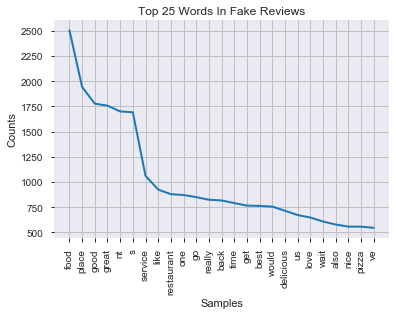

In [26]:
# Plotting word distributions in fake reviews
fakereview_fdist.plot(25,title="Top 25 Words In Fake Reviews")

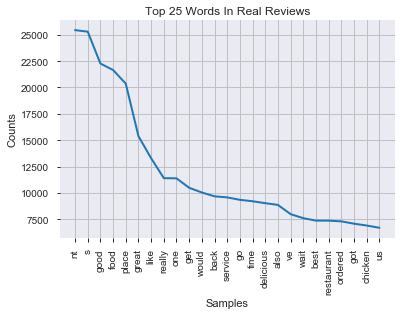

In [27]:
# Plotting word distributions in fake reviews
realreview_fdist.plot(25,title="Top 25 Words In Real Reviews")

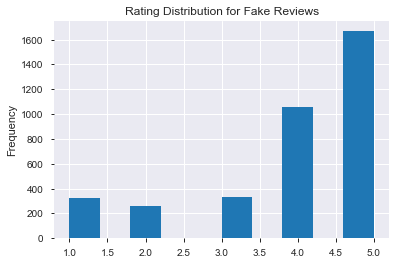

In [28]:
fake_reviews.rating.plot(kind='hist',title='Rating Distribution for Fake Reviews')

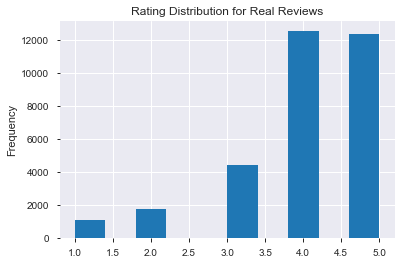

In [29]:
real_reviews.rating.plot(kind='hist',title='Rating Distribution for Real Reviews')

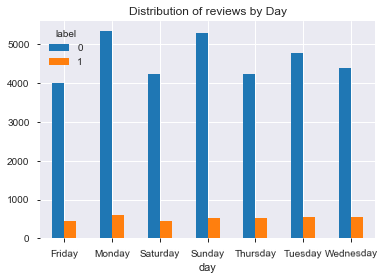

In [30]:
pd.crosstab(data_df.day, data_df.label).plot(kind='bar',rot=1,title='Distribution of reviews by Day')

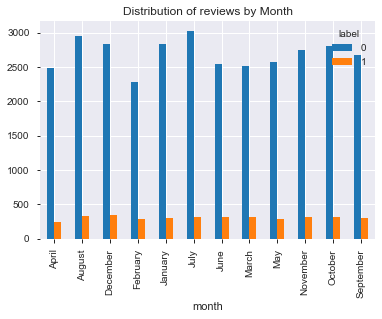

In [31]:
pd.crosstab(data_df.month, data_df.label).plot(kind='bar',title='Distribution of reviews by Month')

In [32]:
# df = data_df[['ex_id','user_id','prod_id','rating','tokens_no_stopwords','bigrams_','day','month']]
# with open(os.path.join(processed_dir,'dev','clean_df_ece278.pkl'),'wb') as f:
#     pickle.dump(df, f)